In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import os

# The local tensor metric :


the local tensor metric defines local metric and is used to calculate short lengths. For a given point $x$ on the sphere of radius $R$ and located with angles $\phi \in ]-\pi,\pi[$ (longitude) and $\theta \in ]-\pi/2,\pi/2[$ (latitude), the local metric tensor is 
$$
g_x = \left( \begin{array} &g _{\phi \phi} & g_{\phi \theta} \\
g_{\theta \phi} & g_{\theta \theta} 
\end{array} \right) =
\left( \begin{array} &R^2 \cos^2 \theta & 0 \\
0 & R^2
\end{array} \right)
$$

In [2]:
n = 140
phi,theta = np.linspace(-np.pi,np.pi,n), np.linspace(-np.pi/2,np.pi/2,n)

deg_to_radian = 2*np.pi/360
#phi,theta = np.linspace(-9.3,67,n) *deg_to_radian, np.linspace(36,70,n)*deg_to_radian #europe
theta, phi = np.linspace(0,60,n) *deg_to_radian, np.linspace(0,60,n)*deg_to_radian #europe

theta, phi = np.meshgrid(theta, phi)

R = 1

ex,ey,ez = np.eye(3)


e_r = np.array([np.cos(theta)*np.cos(phi),
               np.cos(theta)*np.sin(phi),
               np.sin(theta)]).T * R

e_theta = np.array([-np.sin(theta)*np.cos(phi),
               -np.sin(theta)*np.sin(phi),
               np.cos(theta)]).T * R

e_phi = np.array([-np.cos(theta)*np.sin(phi),
                 np.cos(phi)*np.cos(theta),
                 np.cos(theta)*0]).T * R


X = R * np.cos(theta)*np.cos(phi)
Y = R * np.cos(theta)*np.sin(phi)
Z = R * np.sin(theta)

OM = X[:,:,np.newaxis]*ex + Y[:,:,np.newaxis]*ey + Z[:,:,np.newaxis]*ez

def projection(vecteur):
    return (np.dot(vecteur,ex),np.dot(vecteur,ey),np.dot(vecteur,ez))

## initial concentration :

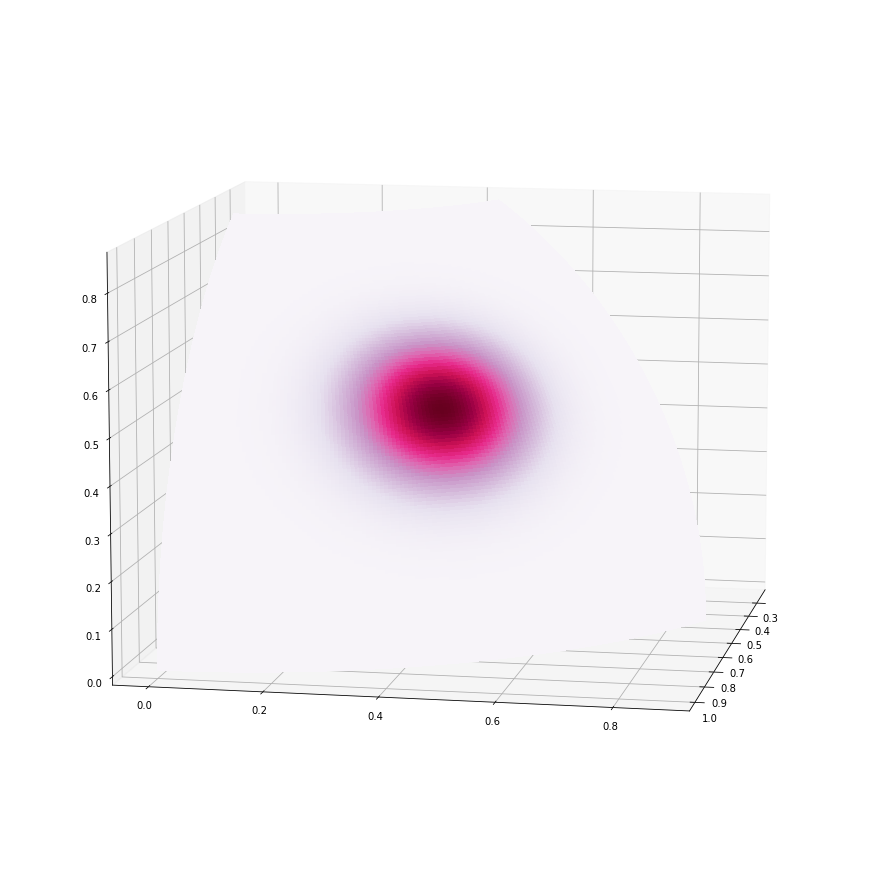

In [3]:
lh = 0.15
index = (n//2,n//2)

distX = X-X[index]
distY = Y-Y[index]
distZ = Z-Z[index]
dist = np.linalg.norm(np.array([distX,distY,distZ]),ord=2,axis=0)  

X0 = np.exp(- dist **2 / lh**2)

from matplotlib import colors, cm
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(elev=10., azim=11)

strength = X0
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.PuRd,
                       linewidth=0, antialiased=False,
                       facecolors=cm.PuRd(norm(strength)),zorder=1)

first we need to build a wind field on the sphere.

## generating an isotropic wind field on a sub-domain of the sphere :

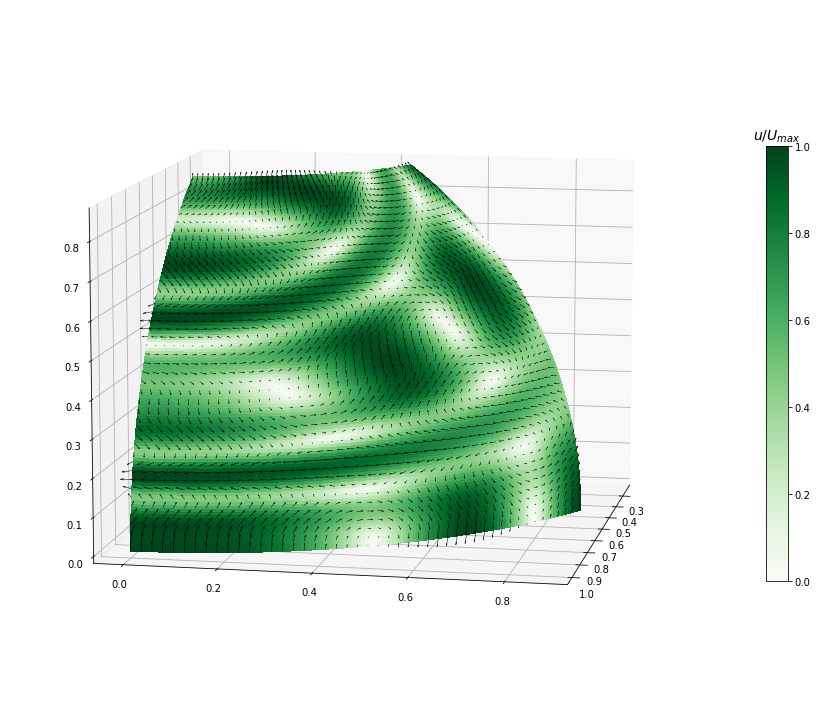

In [4]:
wind_1 = np.cos(X*np.pi*4) * np.cos(Y*np.pi*2.7)
wind_2 = np.sin(Y*np.pi*8.1) * np.sin(Y*np.pi*2.7)

wind_theta = wind_1[np.newaxis].T * e_theta
wind_phi = wind_2[np.newaxis].T * e_phi

wind = np.array([wind_1, wind_2]) #theta, phi
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(1,1,1,projection='3d')
length = .025
ax.view_init(elev=10., azim=11)

ds = 3

strength = np.linalg.norm(np.array([wind_theta, wind_phi]),axis=(0,3))
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.Greens,
                       linewidth=0, antialiased=False,
                       facecolors=cm.Greens(norm(strength)),zorder=1)

ax.quiver(*projection(OM[::ds,::ds]), *projection((wind_phi+wind_theta)[::ds,::ds]), length=length, normalize=False,color='k',zorder=3,linewidth=0.5);
cb = fig.colorbar(surface,ax=ax,shrink=0.5)
cb.ax.set_title(r"$u/U_{max}$",fontsize=14)
#ax.set_title(r"Isotropic wind field $u$",fontsize=14)
plt.show()

## Transport problem :


The transport of a chemical species $\mathcal{X}$ by a wind field $\textbf{u}$ writes:

$$
\partial_t \mathcal{X} + \textbf{u} \nabla \mathcal{X} = 0
$$.


On the unit sphere, parametrized by spherical coordinates $(\theta,\phi)$ (latitude/longitude), the gradient operator $\nabla$ is defined by :

$$
\nabla = \left(\frac{\partial}{\partial \theta}, \frac{1}{\cos \theta} \frac{\partial}{\partial \phi}  \right)
$$


Therefore, in the case of a 2D transport over the unit sphere $\mathbb{S}^2$ ($\textit{i.e.}$ $\textbf{u} = (u_\theta,u_\phi))$, the dynamics of $\mathcal{X} =\mathcal{X}(\theta, \phi)$ rewrites :

$$
\partial_t \mathcal{X} + \left( u_\theta \partial_\theta \mathcal{X} + \frac{u_\phi}{\cos \theta} \partial_\phi \mathcal{X} \right) = 0
$$


If we consider the subdomain of the sphere defined by $(\theta,\phi) \in ]36°,70°[ \times ]-9.30°,67°[$, which correspond to the European continent, this problem correspond to a 2D transport over the flat domain $]36°,70°[ \times ]-9.30°,67°[ \subset \mathbb{R}^2 $, where the new wind field $\tilde{\textbf{u}}$ is defined by :

$$
\tilde{\textbf{u}} = (\tilde{u}_{\theta},\tilde{u}_\phi) = \left( u_\theta, \frac{u_\phi}{\cos \theta} \right)
$$

# building advection 2d class :

In [5]:
from mypackage.problem import Model
from mypackage.domain import Domain2D

class Advection2D(Model):
    def _make_trend(self):
        Ux, Uy = self.trend_parameters[0]  #theta/ phi : latitute/longitude
        self.domain = Domain2D(len(Ux),len(Uy))
        #computing appropriate timestep :
        sup_Ux = np.linalg.norm(Ux,ord=np.inf)
        sup_Uy = np.linalg.norm(Uy,ord=np.inf)
        self.dt = min(self.domain.dx/sup_Ux, self.domain.dy/sup_Uy) *0.9
        def trend(state,t):
            dx_state = self.domain.derive(state,axis=0) 
            dy_state = self.domain.derive(state,axis=1) 
            trend_state =  -Ux * dx_state - Uy*dy_state
            return trend_state
        return trend
    

domain2d = Domain2D(n,n)

In [60]:
rayon_terre = 6371 #km
converted_wind = wind/np.linalg.norm(wind,axis=0).max()
max_wind_velocity = 15 #kmh
converted_wind = wind * max_wind_velocity / rayon_terre

# converting to a wind on R^2 :
converted_wind[1] = converted_wind[1] / np.cos(theta)

## forecast :

100%|█████████████████████████████████████████████████████████████████████████████| 8580/8580 [00:16<00:00, 529.81it/s]


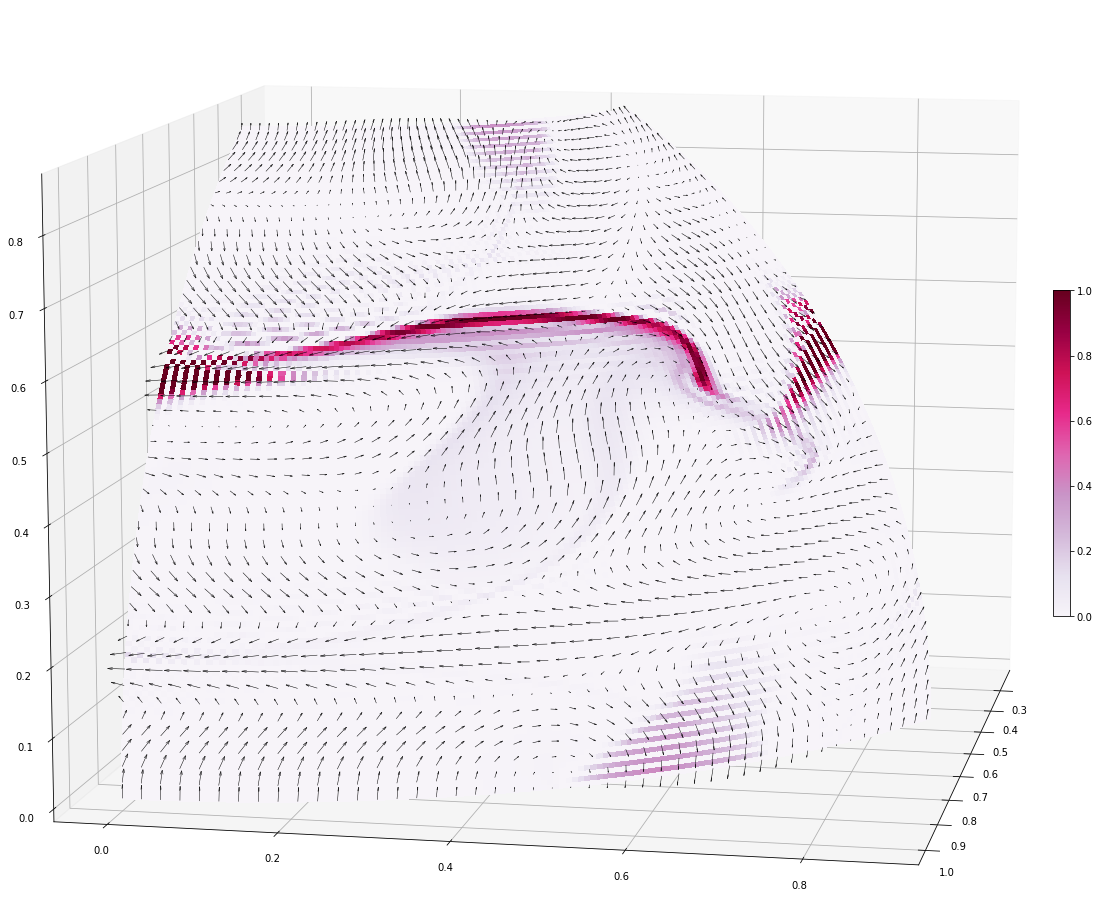

In [61]:
advection2d = Advection2D(X0, [converted_wind],scheme='RK4')
t_end = 200 #hours
advection2d.forecast(t_end)

cwind_theta = converted_wind[0][np.newaxis].T* e_theta
cwind_phi = converted_wind[1][np.newaxis].T  * e_phi



fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.view_init(elev=10., azim=11)
strength = advection2d.x.T
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.PuRd,
                       linewidth=1, antialiased=False,
                       facecolors=cm.PuRd(strength),zorder=1)
ds = 3
length = 0.02
ax.quiver(*projection(OM[::ds,::ds]), *projection((wind_phi+wind_theta)[::ds,::ds]), length=length, normalize=False,color='k',zorder=3,linewidth=0.5);
ax.dist = 7
cb = fig.colorbar(surface,ax=ax,shrink=0.3)
plt.show()

In [62]:
def index_img(index):
    if index < 10 :
        return '00'+str(index) 
    elif 10<= index < 100 :
        return '0'+str(index) 
    else:
        return index

In [82]:
import os
from tqdm import tqdm

advection2d = Advection2D(X0, [converted_wind],scheme='RK4',time_saving_interval=np.inf)
t_end = 150 #hours

n_iter = int(t_end // advection2d.dt)

path = '../../../Pictures/plots/'
for file in os.listdir(path):
    os.remove(path + file)
    
norm=colors.Normalize(vmin = 0,
                      vmax = 2, clip = False)
ds = 3
length = 0.02

index_save = 0
length = 0.02

for i in tqdm(range(n_iter),position=0,leave=True):
    
    if i % 50 ==0 :
        fig = plt.figure(figsize=(35,35))
        ax = fig.add_subplot(1,1,1,projection='3d')

        ax.view_init(elev=10., azim=11)

        strength = advection2d.x.T

        surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.PuRd,
                               linewidth=1, antialiased=False,
                               facecolors=cm.PuRd(norm(strength)),zorder=1)
        ax.quiver(*projection(OM[::ds,::ds]), *projection((wind_phi+wind_theta)[::ds,::ds]), length=length, normalize=False,color='k',zorder=3,linewidth=0.5);
        ax.dist = 7
        cb = fig.colorbar(surface,ax=ax,shrink=0.3)

        fig.savefig(path + f'img{index_img(index_save)}')
        index_save+=1
        plt.clf()
    advection2d._step()
    #plt.show()

import glob
from PIL import Image
print("making the GIF file...")
# filepaths
fp_in = "../../../Pictures/plots/img*.png"
fp_out = "../../../Pictures/plots/out.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

path = '../../../Pictures/plots/'
for file in os.listdir(path).remove('out.gif'):
    os.remove(path + file)

from IPython.display import display, HTML

HTML('''<div style="display: flex; justify-content: row;">
    <img src="../../../Pictures/plots/out.gif">
</div>''')

 15%|████████████▏                                                                  | 995/6434 [01:13<04:34, 19.79it/s]<ipython-input-82-3d150c5abe70>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(35,35))
100%|██████████████████████████████████████████████████████████████████████████████| 6434/6434 [06:56<00:00, 15.44it/s]


making the GIF file...


TypeError: 'NoneType' object is not iterable

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>

<Figure size 2520x2520 with 0 Axes>